In [1]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import skimage
from PIL import Image
from detection_utils import *
from keypoint_utils import *

import importlib
from sklearn.metrics import mean_squared_error
import json
import yaml
import time
import supervision as sv
from inference import get_model
print(sv.__version__)


[01/07/25 09:28:26] WARNING  Your inference package version 0.30.0 is out of date! Please upgrade to ]8;id=238717;file:///home/gp106653/miniconda3/envs/soccer/lib/python3.8/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=510746;file:///home/gp106653/miniconda3/envs/soccer/lib/python3.8/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.32.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

0.22.0


In [2]:
src="./videos/dbf_2.mp4"


In [3]:
model = get_model(
    model_id="football-ball-detection-rejhg/4", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


In [4]:
model_keypoints = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


In [5]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
# Specify the path to the video file
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
else:
# Read the first frame
    pass

# Get video properties for output writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))




slice_dimensions = (640, 480)  # Width and height for slicing
overlap_dimensions = (100, 100)  # Overlap between slices
slice_wh=slice_dimensions
overlap_wh=overlap_dimensions

frame_number=0
# Initialize the BallTracker
tracker = centroid_track.BallTracker(buffer_size=5)


# Intialize DeepSort

ball_positions = []
yolo_detections=[]
first=False
all_frames=[]
frame_number=0
# Read all the frames
all_keypoints=[]
det_conf=0.4
keyp_conf=0.8
while True:
    ret, frame = cap.read()
    if not ret:
        break
    all_frames.append(frame)
    #Run ball detection inference on patches
    #patches = slice_frame(frame, slice_wh, overlap_wh)
    #detection_frame,det_ball = infer_on_patches(model, patches, frame_number,0.6,0.4)

    #Run ball detection inference on a single FRAME
    detection_frame=normal_prediction(model, frame, frame_number,0.6,0.4)

    print(" detection frame length is:  ",len(detection_frame))
    if len(detection_frame)>1:
        print("================Multiple BALL DETECTION==================")

    ## Run keypoint detection inference on single Frame

    kpoints = keypoint_utils.keypoint_prediction(model_keypoints,frame,det_conf,keyp_conf)
    all_keypoints.append(kpoints)


    det=False
    detections_track = []

    if isinstance(detection_frame, np.ndarray) and detection_frame.size > 0:  # Check if it's a NumPy array with elements
        print("inside the FIRST instance-----111")
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            detections_track.append([x_centroid,y_centroid ])  # Append the centroid
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)

        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
    elif isinstance(detection_frame, list) and len(detection_frame) > 0:  # Check if it's a non-empty list
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            
            detections_track.append([x_centroid,y_centroid ]) 
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)
        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
    else:
        print("Inside none tracker-------")
        tracked_ball = tracker.update(None)  
        ball_positions.append((np.nan,np.nan))
        det=False
    print("The ball position is: ",ball_positions)
    print("The frame number is :",frame_number)
    frame_number+=1
    if frame_number==20:
        break
# Release the video capture object
cap.release()



        




 detection frame length is:   1
The predictions are:  [KeypointsPrediction(x=959.5, y=705.5, width=1919.0, height=749.0, confidence=0.9832988977432251, class_name='pitch', class_confidence=None, class_id=0, tracker_id=None, detection_id='d0abaa9d-a23e-4464-ac7b-ddd5858e98fb', parent_id=None, keypoints=[Keypoint(x=16.0, y=410.0, confidence=9.834766387939453e-07, class_id=0, class_name='01'), Keypoint(x=0.0, y=452.0, confidence=1.1920928955078125e-07, class_id=1, class_name='02'), Keypoint(x=0.0, y=523.0, confidence=5.960464477539063e-08, class_id=2, class_name='03'), Keypoint(x=0.0, y=697.0, confidence=0.0, class_id=3, class_name='04'), Keypoint(x=0.0, y=715.0, confidence=0.0, class_id=4, class_name='05'), Keypoint(x=1000.0, y=827.0, confidence=8.940696716308594e-08, class_id=5, class_name='06'), Keypoint(x=0.0, y=527.0, confidence=8.940696716308594e-08, class_id=6, class_name='07'), Keypoint(x=0.0, y=649.0, confidence=2.9802322387695312e-08, class_id=7, class_name='08'), Keypoint(x=0.0

In [11]:
print(len(ball_positions))
print(len(all_frames))
print(len(all_keypoints))

20
20
20


In [8]:
yolo=False
df_positions = pd.DataFrame(ball_positions, columns=["x", "y"])
df_positions = df_positions.interpolate(method="linear").bfill()  # Interpolate missing values
position_array=list(df_positions.values)

# Define the codec and create VideoWriter object
output_path = './videos/dbf_2_out.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MP4V' for MP4 files
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

for current_positions,frame in zip(position_array,all_frames):
 
    

    # Get the current interpolated position for this frame
    x, y = current_positions
    
    if not np.isnan(x) and not np.isnan(y):
        
        x, y = int(x), int(y)
        # Draw interpolated circle
        cv2.circle(frame, (x, y), radius=10, color=(0, 0, 255), thickness=2)

    #Draw raw detections from YOLO
    if yolo:

        x1=int(x1)
        x2=int(x2)
        y1=int(y1)
        y2=int(y2)
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
        x,y,w,h=xyxy2xywh(x1,y1,x2,y2)






    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    out.write(frame)
    

In [12]:
print(len(position_array))
position_array[0]

20


array([        681,         651])

keypoints adta is:  {'keypoints': (1052.0, 421.0), 'class': '20', 'conf': 0.9998083710670471}
keypoints adta is:  {'keypoints': (1192.0, 489.0), 'class': '21', 'conf': 0.9999188184738159}
keypoints adta is:  {'keypoints': (1414.0, 596.0), 'class': '22', 'conf': 0.9989910125732422}
keypoints adta is:  {'keypoints': (1677.0, 723.0), 'class': '23', 'conf': 0.9539748430252075}
keypoints adta is:  {'keypoints': (1477.0, 528.0), 'class': '24', 'conf': 0.9985800981521606}
keypoints adta is:  {'keypoints': (1508.0, 463.0), 'class': '25', 'conf': 0.9984670281410217}
keypoints adta is:  {'keypoints': (1840.0, 586.0), 'class': '26', 'conf': 0.8093938231468201}
keypoints adta is:  {'keypoints': (1335.0, 347.0), 'class': '27', 'conf': 0.9914171695709229}
keypoints adta is:  {'keypoints': (1496.0, 402.0), 'class': '28', 'conf': 0.9965713620185852}
keypoints adta is:  {'keypoints': (1661.0, 456.0), 'class': '29', 'conf': 0.9870901703834534}
keypoints adta is:  {'keypoints': (289.0, 601.0), 'class': '

True

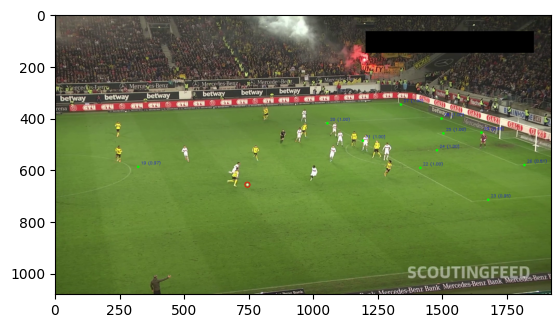

In [15]:
from soccer_config import SoccerPitchConfiguration
import keypoint_homography
from keypoint_homography import Transform
CONFIG = SoccerPitchConfiguration()

In [116]:
index_frame_number=19

keypoints adta is:  {'keypoints': (1052.0, 421.0), 'class': '20', 'conf': 0.9998083710670471}
keypoints adta is:  {'keypoints': (1192.0, 489.0), 'class': '21', 'conf': 0.9999188184738159}
keypoints adta is:  {'keypoints': (1414.0, 596.0), 'class': '22', 'conf': 0.9989910125732422}
keypoints adta is:  {'keypoints': (1677.0, 723.0), 'class': '23', 'conf': 0.9539748430252075}
keypoints adta is:  {'keypoints': (1477.0, 528.0), 'class': '24', 'conf': 0.9985800981521606}
keypoints adta is:  {'keypoints': (1508.0, 463.0), 'class': '25', 'conf': 0.9984670281410217}
keypoints adta is:  {'keypoints': (1840.0, 586.0), 'class': '26', 'conf': 0.8093938231468201}
keypoints adta is:  {'keypoints': (1335.0, 347.0), 'class': '27', 'conf': 0.9914171695709229}
keypoints adta is:  {'keypoints': (1496.0, 402.0), 'class': '28', 'conf': 0.9965713620185852}
keypoints adta is:  {'keypoints': (1661.0, 456.0), 'class': '29', 'conf': 0.9870901703834534}
keypoints adta is:  {'keypoints': (289.0, 601.0), 'class': '

True

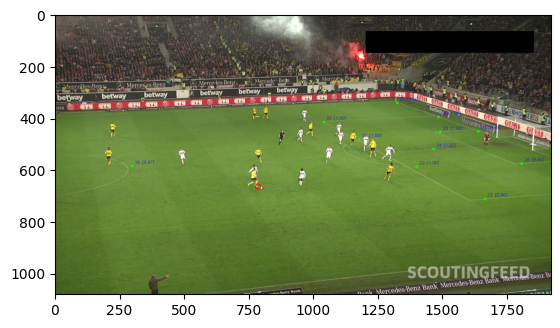

In [135]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
keypoint_frames=keypoint_utils.draw_keypoints(all_keypoints,all_frames)
plt.figure()

plt.imshow(keypoint_frames[index_frame_number])
fr=keypoint_frames[index_frame_number]
frame_rgb=cv2.cvtColor(fr, cv2.COLOR_BGR2RGB) 
cv2.imwrite("keypoints_field.png",frame_rgb )

In [118]:
vert=CONFIG.vertices
print(vert)

[(0, 0), (0, 1450.0), (0, 2584.0), (0, 4416.0), (0, 5550.0), (0, 7000), (550, 2584.0), (550, 4416.0), (1100, 3500.0), (2015, 1450.0), (2015, 2584.0), (2015, 4416.0), (2015, 5550.0), (6000.0, 0), (6000.0, 2585.0), (6000.0, 4415.0), (6000.0, 7000), (9985, 1450.0), (9985, 2584.0), (9985, 4416.0), (9985, 5550.0), (10900, 3500.0), (11450, 2584.0), (11450, 4416.0), (12000, 0), (12000, 1450.0), (12000, 2584.0), (12000, 4416.0), (12000, 5550.0), (12000, 7000), (5085.0, 3500.0), (6915.0, 3500.0)]


In [143]:
vert[4]

(0, 5550.0)

In [120]:
len(all_keypoints)

20

In [121]:
kpts=all_keypoints[index_frame_number]
print(kpts)
print(len(kpts))

[{'keypoints': (1038.0, 416.0), 'class': '20', 'conf': 0.9998369216918945}, {'keypoints': (1175.0, 483.0), 'class': '21', 'conf': 0.9999394416809082}, {'keypoints': (1397.0, 588.0), 'class': '22', 'conf': 0.9991497993469238}, {'keypoints': (1660.0, 712.0), 'class': '23', 'conf': 0.9642915725708008}, {'keypoints': (1462.0, 520.0), 'class': '24', 'conf': 0.9986863732337952}, {'keypoints': (1488.0, 455.0), 'class': '25', 'conf': 0.9986988306045532}, {'keypoints': (1802.0, 577.0), 'class': '26', 'conf': 0.857509970664978}, {'keypoints': (1322.0, 343.0), 'class': '27', 'conf': 0.9958832859992981}, {'keypoints': (1481.0, 397.0), 'class': '28', 'conf': 0.9974105358123779}, {'keypoints': (1635.0, 452.0), 'class': '29', 'conf': 0.988584041595459}, {'keypoints': (297.0, 586.0), 'class': '19', 'conf': 0.9703149795532227}]
11


In [122]:
final_vert=[]
final_kpts=[]
for item in kpts:
    indx=int(item["class"])
    print("The index",indx)
    final_kpts.append(item["keypoints"])
    final_vert.append(vert[indx])

The index 20
The index 21
The index 22
The index 23
The index 24
The index 25
The index 26
The index 27
The index 28
The index 29
The index 19


In [123]:
print("Final vertices are: ",final_vert)
print("Final keypoints are: ",final_kpts)

Final vertices are:  [(9985, 5550.0), (10900, 3500.0), (11450, 2584.0), (11450, 4416.0), (12000, 0), (12000, 1450.0), (12000, 2584.0), (12000, 4416.0), (12000, 5550.0), (12000, 7000), (9985, 4416.0)]
Final keypoints are:  [(1038.0, 416.0), (1175.0, 483.0), (1397.0, 588.0), (1660.0, 712.0), (1462.0, 520.0), (1488.0, 455.0), (1802.0, 577.0), (1322.0, 343.0), (1481.0, 397.0), (1635.0, 452.0), (297.0, 586.0)]


In [124]:
final_vert_array=np.array(final_vert)
final_kpts_array=np.array(final_kpts)

In [125]:

transformer = Transform(
    source=final_kpts_array.astype(np.float32),
    target=final_vert_array.astype(np.float32)
)


In [126]:
pts_2d=position_array[index_frame_number].reshape(1, -1) 
pts_2d

array([[        784,         665]])

In [127]:

final_img=transformer.transform_points(points=pts_2d)

In [128]:
final_img

array([[      11290,      3652.7]], dtype=float32)

11289.533 3652.7183


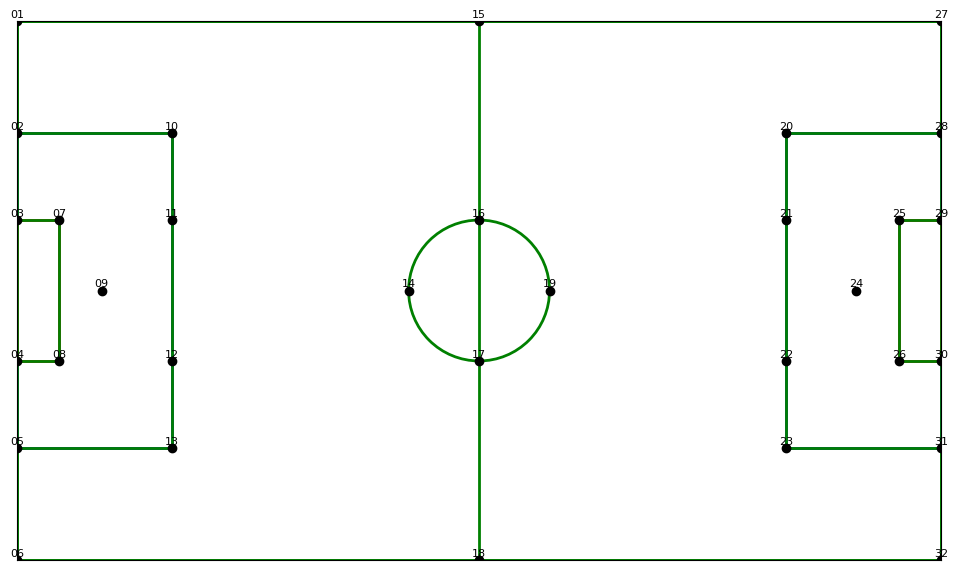

In [138]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from soccer_config import SoccerPitchConfiguration

pitch = SoccerPitchConfiguration()
fig, ax = plt.subplots(figsize=(12, 7))

ax.set_xlim(0, pitch.length)
ax.set_ylim(pitch.width, 0)  #

# Invert the y-axis to match OpenCV's coordinate system


# Plot the outer boundary of the field
field_outline = patches.Rectangle((0, 0), pitch.length, pitch.width, linewidth=2, edgecolor="green", facecolor="none")
ax.add_patch(field_outline)

# Plot the centre circle
centre_circle = patches.Circle((pitch.length / 2, pitch.width / 2), pitch.centre_circle_radius, linewidth=2, edgecolor="green", facecolor="none")
ax.add_patch(centre_circle)

# Plot the penalty boxes
penalty_box1 = patches.Rectangle((0, (pitch.width - pitch.penalty_box_width) / 2), pitch.penalty_box_length, pitch.penalty_box_width, linewidth=2, edgecolor="blue", facecolor="none")
penalty_box2 = patches.Rectangle((pitch.length - pitch.penalty_box_length, (pitch.width - pitch.penalty_box_width) / 2), pitch.penalty_box_length, pitch.penalty_box_width, linewidth=2, edgecolor="blue", facecolor="none")
ax.add_patch(penalty_box1)
ax.add_patch(penalty_box2)

# Plot the goal boxes
goal_box1 = patches.Rectangle((0, (pitch.width - pitch.goal_box_width) / 2), pitch.goal_box_length, pitch.goal_box_width, linewidth=2, edgecolor="red", facecolor="none")
goal_box2 = patches.Rectangle((pitch.length - pitch.goal_box_length, (pitch.width - pitch.goal_box_width) / 2), pitch.goal_box_length, pitch.goal_box_width, linewidth=2, edgecolor="red", facecolor="none")
ax.add_patch(goal_box1)
ax.add_patch(goal_box2)

# Plot the edges (lines connecting the vertices)
for edge in pitch.edges:
    x1, y1 = pitch.vertices[edge[0] - 1]
    x2, y2 = pitch.vertices[edge[1] - 1]
    ax.plot([x1, x2], [y1, y2], color="green", lw=2)

# Plot and annotate the 32 points
for idx, (x, y) in enumerate(pitch.vertices):
    ax.scatter(x, y, color="black", zorder=5)  # Draw the point
    ax.text(x, y - 90, pitch.labels[idx], fontsize=8, ha='center', va='center', color="black", zorder=6)  # Annotate the point

# Plot the ball at the transformed position (xy)
ball_x, ball_y = final_img[0]  # Extract the x, y position of the ball
print(ball_x, ball_y)
ball_radius = 50  # Radius of the ball (adjust as needed)
ball = patches.Circle((ball_x, ball_y), ball_radius, linewidth=2, edgecolor="red", facecolor="blue")
#ax.add_patch(ball)

# Set aspect ratio and remove axis ticks
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
output_path = "soccer_pitch_top_left.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0)
# Show the plot
plt.show()


In [176]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from soccer_config import SoccerPitchConfiguration
# Define the image size (in pixels)
img_width = 1200
img_height = 700

# Initialize soccer pitch configuration
pitch = SoccerPitchConfiguration()

# Create a blank image (white background)
img = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255

# Define scaling factors based on physical dimensions
x_scale = img_width / pitch.length
y_scale = img_height / pitch.width

# Function to scale coordinates
def scale_coordinates(x, y):
    return int(x * x_scale), int(y * y_scale)

# List to store the scaled coordinates
scaled_coord = []

# Plot the vertices and edges
for idx, (x, y) in enumerate(pitch.vertices):
    x_scaled, y_scaled = scale_coordinates(x, y)
    # Draw the vertex as a small circle
    cv2.circle(img, (x_scaled, y_scaled), 5, (0, 0, 0), -1)  # Black dot for the vertex
    # Annotate the point with label (if you need this step)
    cv2.putText(img, pitch.labels[idx], (x_scaled + 10, y_scaled + 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Save the scaled coordinates
    scaled_coord.append((x_scaled, y_scaled))

# Plot the edges (lines connecting the vertices)
for edge in pitch.edges:
    # Get the start and end vertices of the edge
    x1, y1 = pitch.vertices[edge[0] - 1]
    x2, y2 = pitch.vertices[edge[1] - 1]
    
    # Scale the coordinates to image space
    x1_scaled, y1_scaled = scale_coordinates(x1, y1)
    x2_scaled, y2_scaled = scale_coordinates(x2, y2)
    
    # Draw the line between the two points (green color)
    cv2.line(img, (x1_scaled, y1_scaled), (x2_scaled, y2_scaled), (0, 255, 0), 2)  # Green color for edges

# Plot the center circle
center_x, center_y = pitch.length / 2, pitch.width / 2  # The center of the field
center_scaled_x, center_scaled_y = scale_coordinates(center_x, center_y)  # Scale to image coordinates
centre_circle_radius_scaled = pitch.centre_circle_radius * x_scale  # Scale the radius to match the image

# Draw the center circle
cv2.circle(img, (center_scaled_x, center_scaled_y), int(centre_circle_radius_scaled), (0, 255, 0), 2)  # Green circle

# Save the figure as an image file
cv2.imwrite("soccer_pitch_with_circle_scaled_cv2.png", img)


True

In [177]:
scaled_coord

[(0, 0),
 (0, 145),
 (0, 258),
 (0, 441),
 (0, 555),
 (0, 700),
 (55, 258),
 (55, 441),
 (110, 350),
 (201, 145),
 (201, 258),
 (201, 441),
 (201, 555),
 (600, 0),
 (600, 258),
 (600, 441),
 (600, 700),
 (998, 145),
 (998, 258),
 (998, 441),
 (998, 555),
 (1090, 350),
 (1145, 258),
 (1145, 441),
 (1200, 0),
 (1200, 145),
 (1200, 258),
 (1200, 441),
 (1200, 555),
 (1200, 700),
 (508, 350),
 (691, 350)]

(700, 1200, 3)


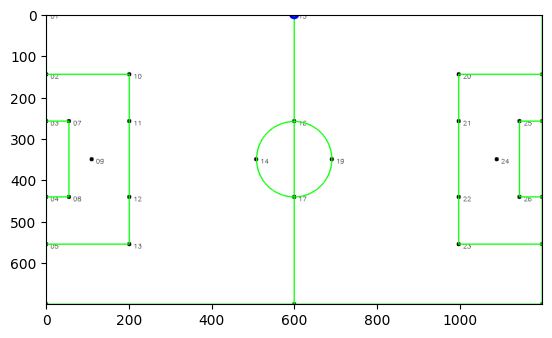

In [195]:
img=cv2.imread("soccer_pitch_with_circle_scaled_cv2.png")
# Plot the coordinate on the image
print(img.shape)
# Define the point where the circle will be drawn
center = scaled_coord[13]  # Example center coordinates in (x, y)

# Define the radius of the circle
radius = 9  # You can adjust this value as needed

# Define the color of the circle (BGR format)
color = (0, 0, 255)  # Red color

# Define the thickness of the circle's border
thickness = 5  # If you want a filled circle, use -1 for thickness

# Draw the circle on the image
cv2.circle(img, center, radius, color, thickness)
plt.imshow(img)

In [146]:
img.shape

(1654, 2814, 3)

In [45]:
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)
frame_nu=10
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nu)

# Read the specific frame
success, frame = cap.read()
frame_rgb=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 

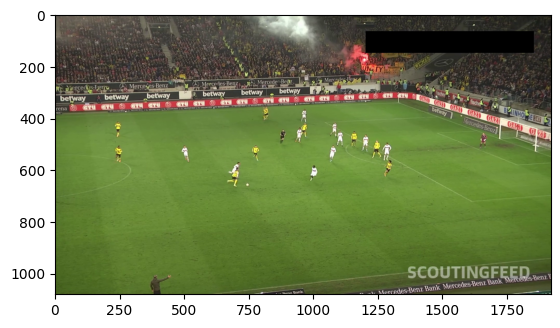

In [48]:
plt.imshow(frame_rgb)

In [53]:
result = model_keypoints.infer(frame_rgb, confidence=0.3)[0]


In [54]:
detections = sv.Detections.from_inference(result)
detections

Detections(xyxy=array([[          0,         329,        1920,        1080]]), mask=None, confidence=array([    0.98742]), class_id=array([0]), tracker_id=None, data={'class_name': array(['pitch'], dtype='<U5')})

In [55]:
xy=detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
            

In [56]:
xy

array([[        960,        1080]])